In [0]:
import numpy as np
from scipy.misc import imread, imresize, imshow, bytescale # image manipulation functions
from glob import glob # helps find files in a folder
import os, sys # to navigate through filesystem
from google.colab import drive # needed to connect to drive
import matplotlib.pyplot as plt # need to plot images
import tensorflow as tf # tensorflow during training
import cv2

In [0]:
os.system('pip3 install -q tflearn')
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d, global_avg_pool
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.normalization import batch_normalization as bn
from tflearn.activations import relu # rectified linear activation function
from tflearn.layers.estimator import regression  # trainer for the network

# turns scalar label into vector where appropriate class is value 1 and others 0
from tflearn.data_utils import to_categorical  

# makes new images from the ones we have by flipping them, rotating, etc.
from tflearn.data_augmentation import ImageAugmentation

# to visualize the data space
from tensorflow.contrib.tensorboard.plugins import projector

In [0]:
def install_tensorboard_dep():
  '''Installs tensorboard to be used in colab.'''
  if 'ngrok-stable-linux-amd64.zip' not in os.listdir(os.getcwd()):
    !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
    !unzip ngrok-stable-linux-amd64.zip
    os.system('n')

In [0]:
def montage(x, plot_shape=(15, 15), return_grid=False, cmap='viridis'):
  '''
  Takes in a 4-D tensor, x, of shape [NxHxWxC] and puts all of the images
  together in a single matrix to show as one image. If return_grid is True, 
  it will not show the matrix, but return it to be used in some other 
  operations.
  '''
  
  count = 0
  if not return_grid:
    scale = [0, 255]
  else:
    scale = [0, 1]
  
  
  if len(x.shape) == 4 and x.shape[-1] == 3:
    num, m, n, c = x.shape
  else:
    num, m, n = x.shape
    c = 1
    
  num = int(np.ceil(np.sqrt(num)))
  grid = np.zeros([num*m, num*n, c])
  
  if c == 1:
    grid = grid[..., 0]
  
  for i in range(num):
    for j in range(num):
      if count < x.shape[0]:
        if c == 1:
          grid[i*m:i*m+m, j*n:j*n+n] = bytescale(x[count, ...], 
                                                 low=scale[0], high=scale[1])
        else:
          grid[i*m:i*m+m, j*n:j*n+n, :] = bytescale(x[count, ...],
                                                    low=scale[0], high=scale[1])
        count += 1 
        
  if return_grid:
    return grid
  else:
    fig = plt.figure(figsize=plot_shape)
    a1 = fig.add_subplot(111)
    a1.set_xticks(np.arange(-0.5, num*n, n))
    a1.set_yticks(np.arange(-0.5, num*m, m))
    a1.set_yticklabels([])
    a1.set_xticklabels([])
    a1.imshow(grid, cmap=cmap)
    plt.show()

In [0]:
def start_tensorboard():
  '''Starts tensorboard on colaboratory.'''
  LOG_DIR = '/tmp/tflearn_logs'  # where the log files will go
  get_ipython().system_raw('tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(LOG_DIR))
  get_ipython().system_raw('./ngrok http 6006 &')
  ! curl -s http://localhost:4040/api/tunnels | python3 -c \
  "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [7]:
response = input('Do you want to train a network? (y/n) ') # ask user if they want to train or load

# if input was Y, y, Yes, or yes, Train a network. If not, load a trained one in.
if response in ['Y', 'y', 'Yes', 'yes']:
  Train = True
else:
  Train = False

Do you want to train a network? (y/n) y


In [8]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!apt-get update && apt-get install ffmpeg

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  InRelease
Hit:2 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [83.2 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:12 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [278 kB]
Fetched 525 kB in 2s (299 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is 

In [0]:
!pip3 install -q scikit-video
import skvideo.io # converts video to frames
#videodata = skvideo.io.vread('*.mp4')
#print(videodata.shape)
success = True
while success:
  cv2.imwrite('*.jpg')     # save frame as JPEG file
  print ('Read a new frame: '), success

In [11]:
vidcap = cv2.VideoCapture('big_buck_bunny_720p_5mb.mp4')
success,image = vidcap.read()
count = 0
success = True
while success:
  cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file
  success,image = vidcap.read()
  print ('Read a new frame: '), success
  count += 1

Read a new frame: 


In [12]:
os.getcwd()

'/content'

In [0]:
os.chdir('drive/My Drive/DeepLearningFall2018')

In [0]:
from residual_block import * # import everything from the residual block notebook

In [0]:
def video_loader():
  vid_names = glob('*.mp4') # get all filenames in this location in .mp4
  print(vid_names)
  keep_interval = 5 # how many frames to skip when going back 
  num_past_frames = 4
  vids = np.zeros([0, 150, 150, num_past_frames])
  
  for indx, vid_name in enumerate(vid_names):
    try:
      vid = skvideo.io.vread(vid_name) # read in the image
      print(vid.shape)
    except ValueError:
      continue
    
    # if video is not correct size, resize it
    if vid.shape[1] != 150 or vid.shape[2] != 150:
      vid = [imresize(vid[f, ...], [150, 150]) for f in range(vid.shape[0])]
   
    vid = np.mean(vid, 3, keepdims=True)  #make all frames grayscale
    
    # make empty array to stack frames together in
    vid_stack = np.zeros([vid.shape[0]-num_past_frames*keep_interval, vid.shape[1], vid.shape[2], num_past_frames])
    
    for frame_id in range((num_past_frames-1)*keep_interval, vid.shape[0]):
      #pull out past 4 frames
      past_1 = vid[frame_id-num_past_frames, ...]
      past_2 = vid[frame_id-2*num_past_frames, ...]
      past_3 = vid[frame_id-3*num_past_frames, ...]
      
      # stack them together in channel dimension
      stack = np.concatenate((vid[frame_id, ...], past_1, past_2, past_3), 2)
      
      vid_stack[frame_id-num_past_frames*keep_interval, ...] = stack
      
                          
    vids = np.concatenate((vids, vid_stack), 0)
    
  return vids

In [16]:
os.chdir('data3')
os.listdir()

['drunk_test',
 'sober_test',
 'drunk_train',
 'sober_train',
 'ngrok-stable-linux-amd64.zip',
 'ngrok']

In [0]:
os.chdir('drunk_train')

In [18]:
X = video_loader()

['114drunk.mp4', '117drunk.mp4', '115drunk.mp4', '113drunk.mp4', '116drunk.mp4', '120drunk.mp4', '121drunk.mp4', '119drunk3.mp4', '119drunk2.mp4', '118drunk.mp4', '119drunk4.mp4', '119drunk1.mp4', '122drunk.mp4', '123drunk.mp4', '124drunk.mp4', '131drunk2.mp4', '127drunk.mp4', '128drunk.mp4', '130drunk2.mp4', '130drunk1.mp4', '126drunk.mp4', '125drunk.mp4', '134drunk2.mp4', '134drunk1.mp4', '134drunk4.mp4', '135drunk2.mp4', '138drunk1.mp4', '134drunk3.mp4', '142drunk1.mp4', '138drunk3.mp4', '141drunk.mp4', '142drunk2.mp4', '138drunk2.mp4', '143drunk3.mp4', '143drunk1.mp4', '139drunk.mp4', '147drunk.mp4', '101drunk1.mp4', '143drunk4.mp4', '150drunk.mp4', '146drunk.mp4', '148drunk.mp4', '149drunk.mp4', '104drunk5.mp4', '106drunk.mp4', '104drunk3.mp4', '102drunk.mp4', '104drunk2.mp4', '104drunk1.mp4', '105drunk.mp4', '104drunk4.mp4', '107drunk1.mp4', '110drunk3.mp4', '107drunk2.mp4', '109drunk2.mp4', '110drunk4.mp4', '110drunk1.mp4', '108drunk1.mp4', '108drunk2.mp4', '109drunk1.mp4', '110

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(51, 480, 514, 3)
(51, 354, 316, 3)
(51, 466, 460, 3)
(51, 520, 516, 3)
(51, 448, 458, 3)
(51, 372, 404, 3)
(51, 214, 206, 3)
(51, 198, 180, 3)
(51, 360, 364, 3)
(51, 290, 274, 3)
(51, 232, 240, 3)
(51, 300, 304, 3)
(51, 536, 506, 3)
(51, 468, 524, 3)
(51, 320, 352, 3)
(51, 442, 416, 3)
(51, 456, 432, 3)
(51, 390, 396, 3)
(51, 462, 456, 3)
(51, 534, 502, 3)
(51, 552, 534, 3)
(51, 244, 236, 3)
(51, 304, 280, 3)
(51, 348, 320, 3)
(51, 390, 408, 3)
(51, 350, 370, 3)
(51, 306, 280, 3)
(51, 274, 274, 3)
(51, 254, 250, 3)
(51, 222, 262, 3)
(51, 300, 328, 3)
(51, 266, 270, 3)
(51, 258, 240, 3)
(51, 262, 276, 3)
(51, 524, 520, 3)
(51, 402, 414, 3)
(51, 342, 304, 3)
(51, 318, 330, 3)
(51, 308, 316, 3)
(51, 360, 366, 3)
(51, 336, 334, 3)
(51, 650, 610, 3)
(51, 222, 220, 3)
(51, 244, 254, 3)
(51, 270, 216, 3)
(51, 246, 234, 3)
(51, 278, 270, 3)
(51, 336, 318, 3)
(51, 376, 376, 3)
(51, 296, 274, 3)
(51, 338, 312, 3)
(51, 240, 224, 3)
(51, 326, 308, 3)
(51, 320, 356, 3)
(51, 224, 214, 3)
(51, 382, 

In [19]:
n_drunk_train = X.shape[0]
print(X.shape)

(3162, 150, 150, 4)


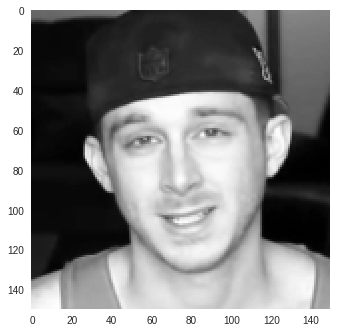

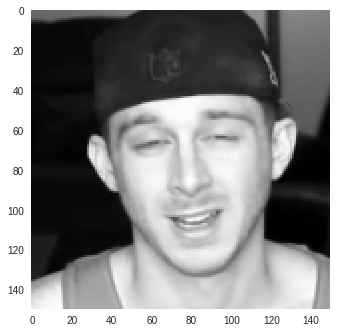

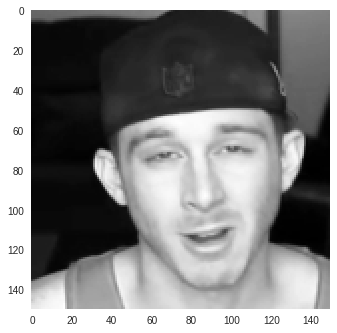

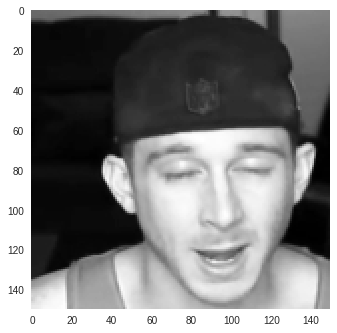

In [20]:
first_img = X[0, ...]  # get first stack
for i in range(4):  #loop through the four frames in that stack
  plt.imshow(first_img[..., i], cmap='gray')  # plot that number frame in the stack
  plt.grid(False) # get rid of grid
  plt.show()

In [0]:
os.chdir('..') # go back a folder
os.chdir('sober_train')

In [22]:
X = np.concatenate((X, video_loader()), 0) # load for the sober folder and then add onto drunk images

['106sober.mp4', '109sober1.mp4', '109sober2.mp4', '110sober.mp4', '107sober.mp4', '111sober2.mp4', '111sober1.mp4', '108sober.mp4', '118sober.mp4', '120sober.mp4', '113sober.mp4', '115sober2.mp4', '117sober2.mp4', '116sober.mp4', '121sober1.mp4', '114sober.mp4', '115sober1.mp4', '119sober.mp4', '121sober2.mp4', '126sober1.mp4', '124sober2.mp4', '123sober1.mp4', '124sober1.mp4', '125sober1.mp4', '126sober3.mp4', '123sober2.mp4', '125sober3.mp4', '122sober.mp4', '127sober1.mp4', '128sober.mp4', '103sober3.mp4', '100sober1.mp4', '101sober1.mp4', '100sober3.mp4', '103sober4.mp4', '101sober2.mp4', '103sober2.mp4', '104sober.mp4', '105sober.mp4', '2013_sober.mp4', '2023_sober.mp4', '2069_sober.mp4', '2105_sober.mp4', '2080_sober.mp4', '2087_sober.mp4', '2080_sober copy.mp4', '2104_sober.mp4', '2106_sober.mp4', '2084_sober.mp4', '2102_sober.mp4', '2109_sober.mp4', '2115_sober copy 11.mp4', '2115_sober copy 3.mp4', '2115_sober copy 5.mp4', '2115_sober copy.mp4', '2112_sober.mp4', '130sober3.m

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(51, 420, 386, 3)
(51, 398, 434, 3)
(51, 262, 268, 3)
(51, 390, 340, 3)
(51, 424, 418, 3)
(51, 432, 428, 3)
(51, 530, 512, 3)
(51, 202, 202, 3)
(51, 314, 336, 3)
(51, 392, 402, 3)
(51, 394, 310, 3)
(51, 320, 308, 3)
(51, 360, 366, 3)
(51, 470, 448, 3)
(51, 492, 458, 3)
(51, 476, 486, 3)
(51, 506, 502, 3)
(51, 428, 382, 3)
(51, 294, 274, 3)
(51, 368, 372, 3)
(51, 322, 314, 3)
(51, 386, 418, 3)
(51, 342, 334, 3)
(51, 288, 274, 3)
(51, 338, 302, 3)
(51, 314, 286, 3)
(51, 460, 462, 3)
(51, 482, 450, 3)
(51, 360, 396, 3)
(51, 270, 278, 3)
(51, 346, 302, 3)
(51, 398, 352, 3)
(51, 300, 288, 3)
(51, 304, 252, 3)
(51, 338, 288, 3)
(51, 294, 234, 3)
(51, 550, 546, 3)
(51, 194, 188, 3)
(51, 242, 208, 3)
(51, 292, 276, 3)
(51, 344, 348, 3)
(51, 382, 378, 3)
(51, 318, 294, 3)
(51, 382, 410, 3)
(51, 316, 282, 3)
(51, 490, 406, 3)
(51, 442, 338, 3)
(51, 426, 300, 3)
(51, 488, 472, 3)
(51, 368, 326, 3)
(51, 210, 168, 3)
(51, 430, 394, 3)
(51, 386, 354, 3)
(51, 306, 292, 3)
(51, 204, 196, 3)
(51, 142, 

In [23]:
X.shape

(6293, 150, 150, 4)

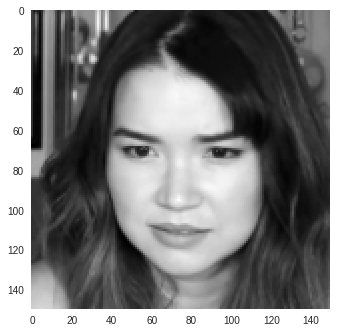

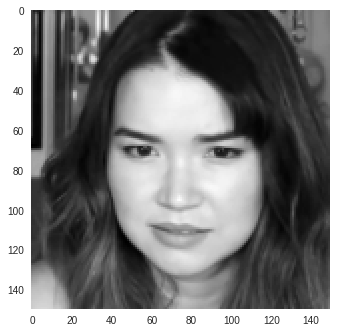

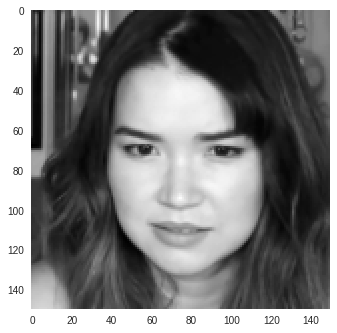

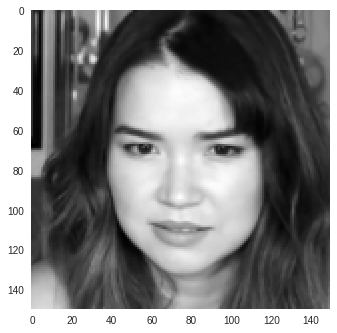

In [24]:
last_img = X[-2, ...]  # get first stack
for i in range(4):  #loop through the five frames in that stack
  plt.imshow(last_img[..., i], cmap='gray')  # plot that number frame in the stack
  plt.grid(False) # get rid of grid
  plt.show()

In [25]:
print(X.shape)
print(n_drunk_train)

(6293, 150, 150, 4)
3162


In [26]:
Y = np.zeros([X.shape[0], ]) # number of rows, number of columns
print(Y.shape)

(6293,)


In [0]:
Y[n_drunk_train:] = 1. # we know that halfway it switches from drunk to sober so we want it labeled 1 for drunk imgs

In [0]:
from tflearn.data_utils import to_categorical # makes the multi-column labels for us
Y = to_categorical(Y, 2) # to_categorical (which column to put the 1, number of classes); for number of labels, make the same amount of columns

In [29]:
Y.shape

(6293, 2)

In [0]:
os.chdir('..') # go back a folder
os.chdir('drunk_test')

In [31]:
testX = video_loader()

['112drunk.mp4', '129drunk.mp4', '131drunk1.mp4', '132drunk.mp4', '136drunk.mp4', '137drunk.mp4', '133drunk.mp4', '135drunk1.mp4', '140drunk.mp4', '143drunk2.mp4', '145drunk.mp4', '101drunk2.mp4', '144drunk.mp4', '153drunk.mp4', '151drunk1.mp4', '161drunk2.mp4', '159drunk2.mp4', '165drunk2.mp4', '166drunk.mp4', '2002_drunk.mp4', '2016_drunk2.mp4', '2021_drunk.mp4', '2049_drunk_2.mp4', '111drunk40.mp4', '103drunk20.mp4']
(51, 428, 414, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(51, 462, 432, 3)
(51, 354, 374, 3)
(51, 388, 406, 3)
(51, 338, 316, 3)
(51, 588, 578, 3)
(51, 702, 688, 3)
(51, 528, 546, 3)
(51, 354, 344, 3)
(51, 330, 346, 3)
(51, 400, 392, 3)
(51, 424, 382, 3)
(51, 452, 476, 3)
(51, 474, 476, 3)
(51, 550, 604, 3)
(51, 284, 294, 3)
(51, 476, 440, 3)
(51, 378, 374, 3)
(51, 526, 532, 3)
(51, 264, 248, 3)
(51, 226, 256, 3)
(51, 232, 262, 3)
(51, 262, 276, 3)
(51, 202, 186, 3)
(51, 400, 432, 3)


In [32]:
n_drunk_test = testX.shape[0]
print(testX.shape)

(775, 150, 150, 4)


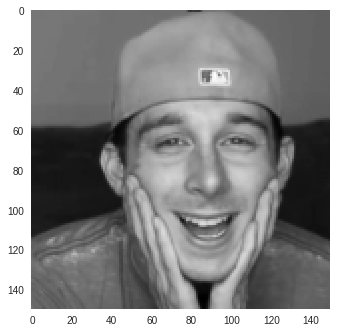

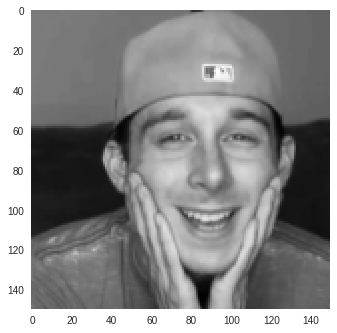

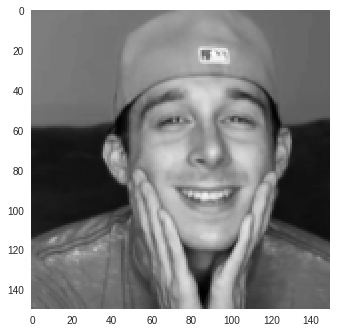

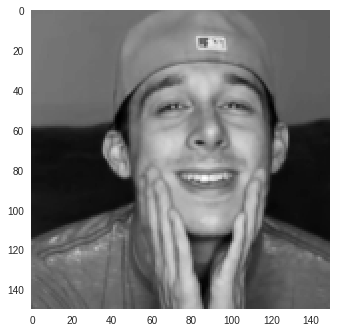

In [33]:
first_img_test = testX[0, ...]  # get first stack
for i in range(4):  #loop through the four frames in that stack
  plt.imshow(first_img_test[..., i], cmap='gray')  # plot that number frame in the stack
  plt.grid(False) # get rid of grid
  plt.show()

In [0]:
os.chdir('..') # go back a folder
os.chdir('sober_test')

In [35]:
testX = np.concatenate((testX, video_loader()), 0) # load for the sober folder and then add onto drunk images

['112sober1.mp4', '112sober2.mp4', '117sober1.mp4', '125sober2.mp4', '125sober4.mp4', '126sober2.mp4', '100sober2.mp4', '127sober2.mp4', '103sober1.mp4', '2115_sober copy 10.mp4', '2115_sober copy2.mp4', '130sober2.mp4', '131sober5.mp4', '131sober3.mp4', '133sober.mp4', '142sober.mp4', '144sober1.mp4', '144sober6.mp4', '144sober8.mp4', '144sober4.mp4', '146sober.mp4', '152sober1.mp4', '156sober3.mp4', '156sober5.mp4', '154sober1.mp4']
(51, 374, 388, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(51, 432, 422, 3)
(51, 316, 306, 3)
(51, 290, 260, 3)
(51, 298, 288, 3)
(51, 250, 288, 3)
(51, 332, 314, 3)
(51, 416, 354, 3)
(51, 324, 328, 3)
(51, 360, 360, 3)
(51, 380, 354, 3)
(51, 142, 154, 3)
(51, 246, 280, 3)
(51, 412, 394, 3)
(51, 352, 362, 3)
(51, 430, 416, 3)
(51, 336, 318, 3)
(51, 330, 302, 3)
(51, 322, 320, 3)
(51, 380, 358, 3)
(51, 402, 366, 3)
(51, 316, 298, 3)
(51, 156, 144, 3)
(51, 192, 164, 3)
(51, 388, 396, 3)


In [36]:
testX.shape

(1550, 150, 150, 4)

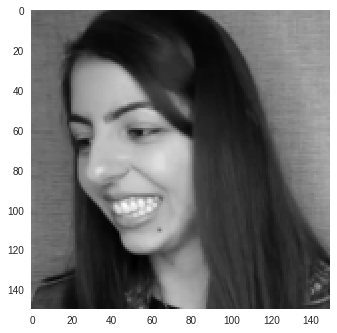

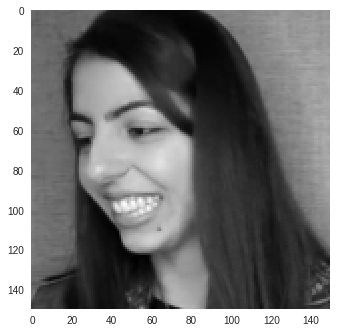

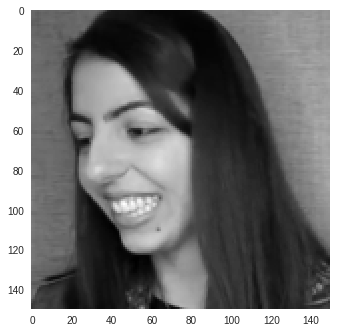

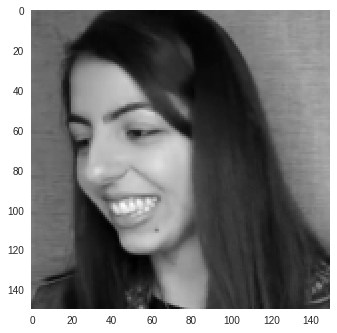

In [37]:
last_img_test = testX[-2, ...]  # get first stack
for i in range(4):  #loop through the five frames in that stack
  plt.imshow(last_img_test[..., i], cmap='gray')  # plot that number frame in the stack
  plt.grid(False) # get rid of grid
  plt.show()

In [38]:
print(testX.shape)
print(n_drunk_test)

(1550, 150, 150, 4)
775


In [39]:
testY = np.zeros([testX.shape[0], ]) # number of rows, number of columns
print(testY.shape)

(1550,)


In [0]:
testY[n_drunk_test:] = 1. # we know that halfway it switches from drunk to sober so we want it labeled 1 for drunk imgs

In [0]:
testY = to_categorical(testY, 2) # to_categorical (which column to put the 1, number of classes); for number of labels, make the same amount of columns

In [42]:
testY.shape

(1550, 2)

In [0]:
os.chdir('..')

**ResNet Model**

In [0]:
tf.reset_default_graph()

In [0]:
# create the input layer for the network
input_layer = input_data(shape=[None, 150, 150, 4])

# first convolution --- 120 x 160 x 32
conv1 = conv_2d(input_layer, 32, 7, strides=2, activation='relu')

# max pooling --- 60 x 80 x 32
pool1 = max_pool_2d(conv1, 3, 2)

# residual blocks 1-3 --- 60 x 80 x 32
residual_block1 = residual_block(pool1, # input to this layer
                                 32, # number of features to look for
                                 3, # filter size
                                 3) # number of residual blocks

# residual blocks 4-7 --- 30 x 40 x 64
residual_block2 = residual_block(residual_block1, # input 
                                 64, # num. features to look for
                                 3, # filter size
                                 4, # number of blocks
                                 2) # stride length 

# residual blocks 8-13 --- 15 x 20 x 128
residual_block3 = residual_block(residual_block2,
                                 128,
                                 3,
                                 6, 
                                 2)

# residual blocks 14-16 --- 7 x 10 x 256
residual_block4 = residual_block(residual_block3,
                                 256,
                                 3,
                                 3,
                                 2)

# global average pooling --- 256
gap = global_avg_pool(residual_block4)

# output layer
output_layer = fully_connected(gap, 2, activation='softmax')

In [0]:
network = regression(output_layer, optimizer='adam', 
                     loss='categorical_crossentropy', learning_rate=.001)

In [0]:
# build the network based on the description above
model = tflearn.DNN(network, tensorboard_verbose=2)

In [64]:
# start tensorboard -- might need to run this code cell twice
install_tensorboard_dep()
start_tensorboard()

https://c73d5b83.ngrok.io


In [0]:
if Train:
  model.fit(X, # input data
            Y, # corresponding labels
            n_epoch=10, # number of times to go through entire dataset
            shuffle=True,   # shuffle the images each epoch
            validation_set=(testX, testY),  # test
            show_metric=True, # show validation accuracy/loss in tensorboard
            batch_size=50,   # go through dataset 50 examples at a time
            run_id='new_drunk_resnet5')  # name that will show up on tensorboard
  
  # saved the trained model for later as the name in red
  model.save('new_drunk_resnet5')

---------------------------------
Run id: new_drunk_resnet5
Log directory: /tmp/tflearn_logs/
INFO:tensorflow:Summary name Accuracy/ (raw) is illegal; using Accuracy/__raw_ instead.
---------------------------------
Training samples: 6293
Validation samples: 1550
--


In [0]:
sess = tf.Session()  # tensorflow session
sess.run(tf.global_variables_initializer())

**Confusion Matrix**

In [1]:
n_classes = 2 # number of classes in your dataset
conf_mat = np.zeros([n_classes, n_classes]) # make confusion matrix

NameError: ignored

In [0]:
for i in range(X.shape[0]): # loop through data samples
  x = X[i, ...] # get that data sample; count up from zero to how many images we have next
  y = np.argmax(Y[i, ...]) # get that sample's labels
  
  output = np.argmax(model.predict(x[None, ...])) # get output of model for x; which class it's most confident about
  
  conf_mat[y, output] += 1. # add 1 to the spot with actual/predicted values

In [53]:
conf_mat # values

array([[3162.,    0.],
       [   0., 3131.]])

Text(0.5,0,'Predicted')

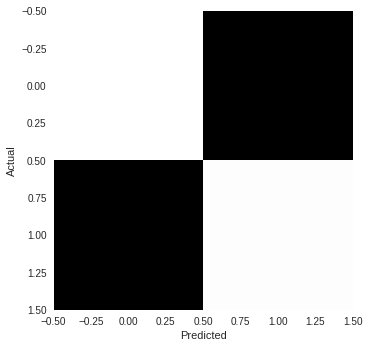

In [54]:
# plot
plt.imshow(conf_mat, cmap='gray') # white = high value, black = low; 100% correct = white along diagonal, nowhere else
plt.grid(False)
plt.ylabel('Actual')
plt.xlabel('Predicted')

**Feature Maps**

In [0]:
# load in feature maps 
def load_layer(layer_name, data):
  layer = sess.run(layer_name, {input_layer:data[None, ...]})
  print(layer.shape)
  return layer

In [0]:
def view_feature_map(layer):
  n, h, w, c = layer.shape # get layer's shape (number, height, width, channels)
  layer = layer.transpose((0, 3, 1, 2)).reshape([n*c, h, w])
  montage(layer, cmap='gray')

In [0]:
from scipy.misc import bytescale

In [0]:
random_index = np.random.randint(0, X.shape[0], 1)[0]
new_img = X[random_index, ...]

(1, 75, 75, 32)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


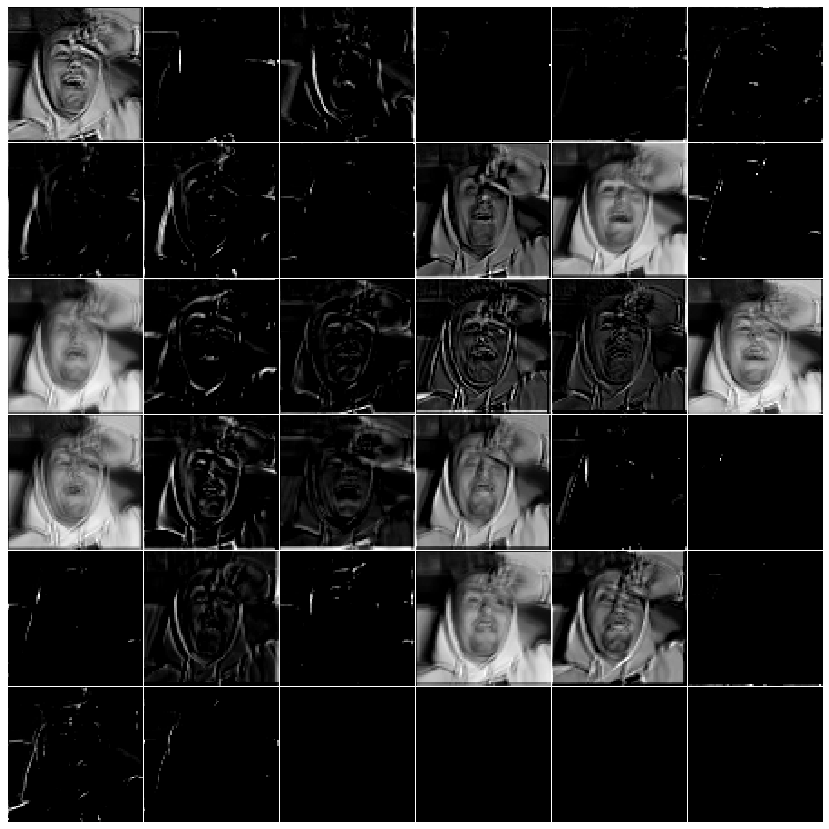

In [66]:
view_feature_map(load_layer(conv1, new_img))

(1, 38, 38, 32)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


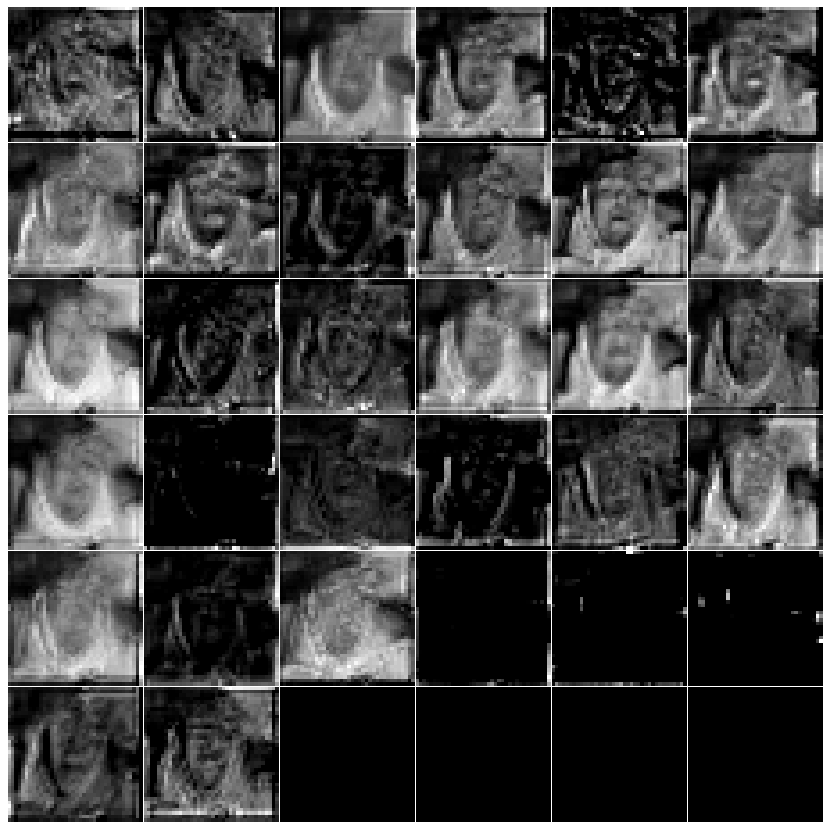

In [67]:
view_feature_map(load_layer(residual_block1, new_img))